In [1]:
import numpy as np
from scipy.interpolate import interp2d, interp1d
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [2]:
data=np.loadtxt('./dn_dM.txt',skiprows=1)
M_list=(data[:,0])
z_list=(data[:,1])
dndzM_list=(data[:,2])
# 对数据进行预处理
M_list_unique = np.unique(M_list)
z_list_unique = np.unique(z_list)

In [3]:
# 1
# 在新的网格上进行二维插值
f_dndzM = interp2d(M_list_unique, z_list_unique, dndzM_list.reshape(len(z_list_unique), len(M_list_unique)), kind='linear')

# 使用二维插值获得任意 M, z 下的 dn/dM
f_dndzM = interp2d(M_list_unique, z_list_unique, dndzM_list)

# 测试插值结果
M_test, z_test = 1e10, 5
print(f_dndzM(M_test, z_test))

[2.64981601e-06]


/tmp/ipykernel_1308/3480452223.py:3: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f_dndzM = interp2d(M_list_unique, z_list_unique, dndzM_list.reshape(len(z_list_unique), len(M_list_unique)), kind='linear')
/tmp/ipykernel_1308/3480452223.py:6: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.


In [4]:
# 定义所需参数
rho_c = 2.7752e11 # h^2 Msun/Mpc^3
h = 0.6774
c=1
Omega_m = 0.32

def Mmin(z):
    return 2.8e9 * (1+z)**(-1.5) # Msun

def integrand(M, z):
    return M * f_dndzM(M, z)

def fcoll(z):
    return quad(integrand, Mmin(z), np.inf, args=(z))[0] / (rho_c * Omega_m)



In [5]:
# 3 
# 计算 z 从 5 到 30 的 fcoll(z)
z_vals = np.linspace(5, 30, 50)

# 数值微分
dz = 0.01
dfcoll_dz = [(fcoll(z+dz) - fcoll(z-dz)) / (2*dz) for z in z_vals[1:-1]]

Omega_b = 0.048
f_star = 0.1

def H(z):
    return 67.72 * np.sqrt(Omega_m*(1+z)**3 + 0.68) # km/s/Mpc

def dz_dt(z):
    return -(1+z)*H(z)

def SFRD(z):
    return (Omega_b/Omega_m) * rho_c * dfcoll_dz[int(z-5)] * dz_dt(z)


/tmp/ipykernel_1308/2385038166.py:11: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  return M * f_dndzM(M, z)
/tmp/ipykernel_1308/2385038166.py:14: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(integrand, Mmin(z), np.inf, args=(z))[0] / (rho_c * Omega_m)


In [6]:
# 4
data=np.loadtxt('./SED.txt',skiprows=1)
nu_list=(data[:,0])
s_list=(data[:,1])
f_s = interp1d(nu_list, s_list, bounds_error=False, fill_value="extrapolate")


/tmp/ipykernel_1308/1703488362.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(integrand_J, 5, 30, args=(nu))[0] / (4*np.pi)


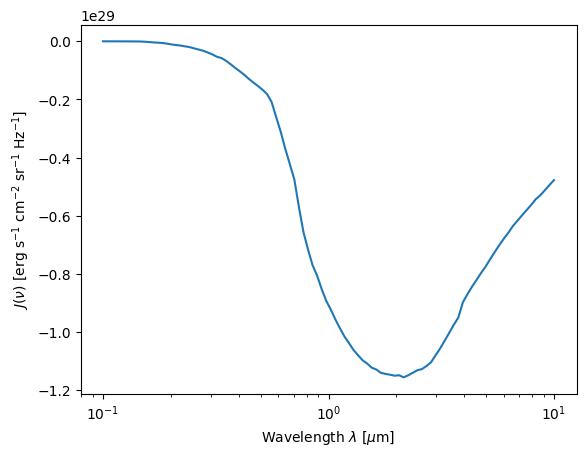

In [7]:
# 5
def integrand_J(z, nu):
    return f_s(nu * (1+z)) * SFRD(z) * c / (H(z)*(1+z))

def J(nu):
    return quad(integrand_J, 5, 30, args=(nu))[0] / (4*np.pi)



# 计算 J(ν) 在 0.1-10 μm 范围内的值
wavelength = np.logspace(-1, 1, 100) # μm
nu = 3e8 / (wavelength * 1e-6) # Hz

J_nu = [J(n) for n in nu]

import matplotlib.pyplot as plt
plt.semilogx(wavelength, J_nu)
plt.xlabel(r"Wavelength $\lambda$ [$\mu$m]")
plt.ylabel(r"$J(\nu)$ [erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ Hz$^{-1}$]")
plt.show()

/tmp/ipykernel_1308/4070611250.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(integrand, 5, 30)[0]


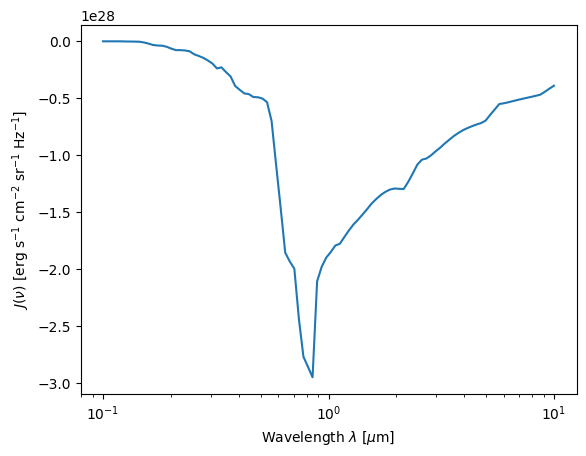

In [8]:
# 6
def tau(nu, z):
    return 0 if nu < 2.47e15 and z < 6 else np.inf

def J_absorbed(nu):
    integrand = lambda z: f_s(nu*(1+z)) * SFRD(z) * np.exp(-tau(nu, z)) / (4*np.pi * H(z) * (1+z))
    return quad(integrand, 5, 30)[0]

# 计算新的 J(ν) 在 0.1-10 μm 范围内的值
J_nu_absorbed = [J_absorbed(n) for n in nu]

plt.semilogx(wavelength, J_nu_absorbed)
plt.xlabel(r"Wavelength $\lambda$ [$\mu$m]")
plt.ylabel(r"$J(\nu)$ [erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ Hz$^{-1}$]")
plt.show()